In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [153]:
data=pandas.read_csv('Files/class_data.csv')
data['label']='data'
data['t_w']=1
data['ltype']=1

In [3]:
def weight_df(df):    
    df['lumiscale'] = df.RunYear.apply(
               lambda x: (36074.6 if (x == 2015 or x == 2016) else 43813.7))
    weights = df.lumiscale*df.pileupEventWeight_090*df.scale_nom*df.JVT_EventWeight*df.MV2c10_70_EventWeight*df.lepSFObjTight*df.lepSFTrigTight*df.SherpaNJetWeight
    return weights


In [154]:
#load MC samples:
def mc_load(labels_list):
    mc_list=[]
    for i in labels_list:
        name='Files/class_mc_'+i+'.csv'
        df=pandas.read_csv(name)
        df['label'] = i
        if i == 'fakes':
            df['t_w'] = 1
        else:
            df['t_w'] = weight_df(df)
        df['ltype']=0
        mc_list.append(df)
        
    mc_df = pandas.concat(mc_list,sort=False)
    return mc_df

In [5]:
def plot_stack_var(df_data,df_bkg,lab_list,var,GeV):
    stack_var=[]
    stack_var_w=[]
    stack_var_leg=[]    
    for i in lab_list:
        stack_var.append(df_bkg[var].loc[df_bkg.label==i]*GeV)
        stack_var_w.append(df_bkg.t_w.loc[df_bkg.label==i])
        stack_var_leg.append(i)

    plt.hist( stack_var, binning[var], histtype='step',
         weights=stack_var_w,
         label=stack_var_leg,
         stacked=True, 
         fill=True, 
         linewidth=2, alpha=0.8)
    plt.hist(df_data[var]*GeV, binning[var], histtype='step',
         label=["data"],
         stacked=False, 
         fill=False, 
         color='k',
         linewidth=2, alpha=0.8)
    plt.xlabel(var,fontsize=12)
    plt.ylabel('# Events',fontsize=12) 
    plt.legend()   

In [6]:
# (best_Z_Mll>0) && abs(lep_ID_0)==abs(lep_ID_1) ) 
#apply additional selections
def apply_3l_Zveto_SF_cuts(df):
    df1=df.loc[abs(df.lep_ID_0)==abs(df.lep_ID_1)]
    df2=df1.loc[df1.best_Z_Mll>0]    
    return df2

In [7]:
scale_to_GeV=0.001
binning = {"DRll01": np.linspace(-2, 6, 24),
           "max_eta": np.linspace(0, 2.5, 26),
           "Mll01": np.linspace(0, 200, 25),
          }
var='Mll01'

In [8]:
labels_list=['ttZ','ttW','ttH','VV','fakes','Others']

In [155]:
bkg_set=mc_load(labels_list)

In [156]:
data_sel=apply_3l_Zveto_SF_cuts(data)
bkg_set_sel=apply_3l_Zveto_SF_cuts(bkg_set)

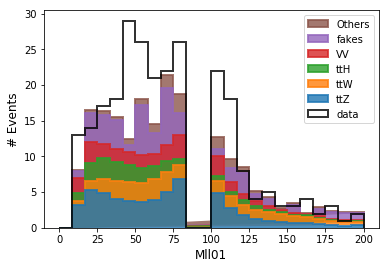

In [157]:
plot_stack_var(data_sel,bkg_set_sel,labels_list,'Mll01',0.001)

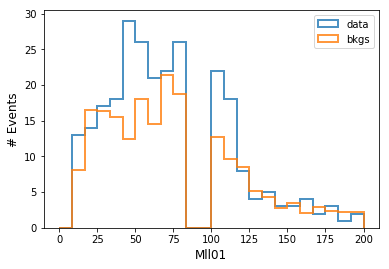

In [158]:
plt.hist(data_sel[var]*scale_to_GeV, binning[var], histtype='step',
         label=["data"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(bkg_set_sel[var]*0.001, binning[var], histtype='step',
         label=["bkgs"],
         weights=bkg_set_sel.t_w,
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.xlabel(var,fontsize=12)
plt.ylabel('# Events',fontsize=12)
#plt.yscale('log')
plt.legend()   

In [159]:
def split_by_Bjet(df):
    df_1b=df.loc[df.nJets_OR_MV2c10_70==1]
    df_2b=df.loc[df.nJets_OR_MV2c10_70>=2]    
    return df_1b,df_2b

In [160]:
def ovr_slot(df_d,df_b,var='Mll01',GeV=0.001,fig_size=(10, 5)):
    f, ax = plt.subplots(figsize=fig_size)
    ax.hist(df_d[var]*GeV, binning[var], histtype='step',
         label=["data"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
    ax.hist(df_b[var]*GeV, binning[var], histtype='step',
         label=["bkgs"],
         weights=df_b.t_w,
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
    ax.set_xlabel(var,fontsize=12)
    ax.set_ylabel('# Events',fontsize=12)    
    ax.legend()   
    return ax


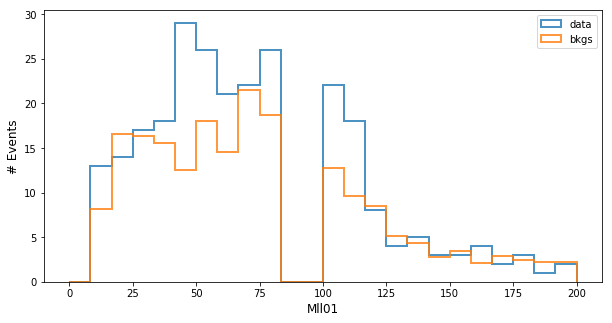

In [161]:
ovr_slot(data_sel,bkg_set_sel)

In [162]:
d_1, d_2 = split_by_Bjet(data_sel)

In [163]:
b_1, b_2 = split_by_Bjet(bkg_set_sel)

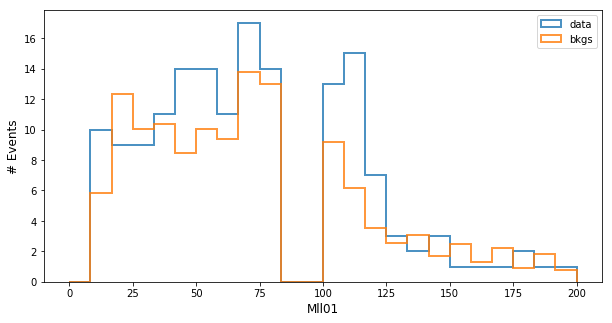

In [164]:
ovr_slot(d_1,b_1)

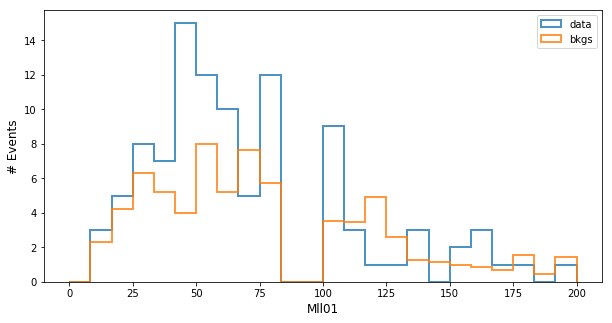

In [165]:
ovr_slot(d_2,b_2)

In [166]:
feature = bkg_set.columns
feature.size

1219

In [167]:
feature[0]
#.str.find('UP')

'entry'

In [168]:
features

['entry',
 'is1L2Tau',
 'is2L2Tau',
 'is2LSS0Tau',
 'pass_tight_2L',
 'pass_SS_2L',
 'is2LSS1Tau',
 'is2LOS1Tau',
 'is3L',
 'is3L1Tau',
 'is4L',
 'is2lLowNJet0Tau',
 'is2LSS0Tau_SR_Relaxed',
 'is2LSS1Tau_SR_Relaxed',
 'is3L0Tau_SR_Relaxed',
 'is3L0Tau_SR_Relaxed3j',
 'is4L_SR_VV_Relaxed',
 'is4L_SR_ttV_Relaxed',
 'is4L_SR_ttV_Zenriched',
 'is3L0Tau_CR_ttbar_Relaxed',
 'is3L0Tau_CR_VV_Relaxed',
 'is3L0Tau_CR_ttW_Relaxed',
 'is2L_VR_ttW_ICHEP',
 'is2L_VR_ttbarFakes_ICHEP',
 'is4lCRttZRelaxed',
 'is2LOS1Tau_CR_ttbar',
 'is2LOS1Tau_CR_ttZ',
 'is2LOS1Tau_CR_W',
 'is3L1Tau_VR',
 'is2lOS0TauBaseline',
 'is2lOS0TauBaseline_ee',
 'is2lOS0TauBaseline_mm',
 'is2lOS0TauBaseline_OF',
 'is2lOS0TauBaseline_me',
 'is2lOS0TauBaseline_em',
 'is2lSS0TauBaseline',
 'is2lSS0TauBaseline_ee',
 'is2lSS0TauBaseline_mm',
 'is2lSS0TauBaseline_OF',
 'is2lSS0TauBaseline_me',
 'is2lSS0TauBaseline_em',
 'is2lOS1TauBaseline',
 'is2lOS1TauBaseline_ee',
 'is2lOS1TauBaseline_mm',
 'is2lOS1TauBaseline_OF',
 'is2lOS1TauBa

In [331]:
def list_branch_to_remove(df,additional_vars=[]):
    syst_list=['UP','DOWN','CRB','scale','weight','SF','Eff',
               'forFit','HLT','tau','MV2c20','is1','is2','is3','is4',
               'ghost','flvWtOrdr','pass']
    syst_list=syst_list+additional_vars
    matches_syst=[]
    features = list(df.columns.values)
    for x in features:
        for j in syst_list:
            if j in x:
                matches_syst.append(x.strip())
    return matches_syst


In [170]:
data_sel_trim = data_sel.drop(list_branch_to_remove(data_sel),axis=1)

In [171]:
bkg_set_sel_trim = bkg_set_sel.drop(list_branch_to_remove(bkg_set_sel),axis=1)

In [188]:
data_sel_trim1.columns

Index(['entry', 'isGNv02', 'minOSMll', 'DEtall01', 'DEtall02', 'DEtall12',
       'lep_flavour', 'jet_flavor', 'total_charge_2lSS', 'isExtConv',
       ...
       'lead_jetEta', 'lead_jetPhi', 'lead_jetE', 'sublead_jetPt',
       'sublead_jetEta', 'sublead_jetPhi', 'sublead_jetE', 'label', 't_w',
       'ltype'],
      dtype='object', length=651)

In [187]:
bkg_set_sel_trim.columns

Index(['entry', 'isGNv02', 'minOSMll', 'DEtall01', 'DEtall02', 'DEtall12',
       'lep_flavour', 'jet_flavor', 'total_charge_2lSS', 'isExtConv',
       ...
       'lead_jetEta', 'lead_jetPhi', 'lead_jetE', 'sublead_jetPt',
       'sublead_jetEta', 'sublead_jetPhi', 'sublead_jetE', 'label', 't_w',
       'ltype'],
      dtype='object', length=652)

In [189]:
s = set(data_sel_trim1.columns)
temp3 = [x for x in bkg_set_sel_trim.columns if x not in s]
temp3

['nJets']

In [205]:
bkg_set_sel_trim1 = bkg_set_sel_trim.drop(['nJets'],axis=1)

In [184]:
data_sel_trim1 = data_sel_trim.drop(temp3,axis=1)

In [226]:
X=pandas.concat([data_sel_trim1,bkg_set_sel_trim1])

In [228]:
y=X['ltype']

In [252]:
#X=X.drop(['ltype'],axis=1)
X=X.drop(['t_w'],axis=1)

In [237]:
X=X.drop(['label'],axis=1)

In [302]:
final_clean=[]
for i in X.columns:
    val = X[i].sum()
    if val< -1e+30 or val> 1e+30:
        print(i,val)
        final_clean.append(i)

In [328]:
final_clean

[]

In [301]:
X = X.drop(final_clean,axis=1)

In [307]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler



In [260]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [406]:
X0=list_branch_to_remove(X_noTr,['pileupEventWeight_090'])
#,'isBrems','isTruth','isQMisID','isExtConv','isConv','isIntConv','isISR''isttGamma']

In [407]:
X0

['pileupEventWeight_090']

In [408]:
X_noTr= X_noTr.drop(X0,axis=1)
#['lep_truthType_0'].head()# 

In [396]:
X_noTr=X_noTr.drop(['RunNumber'],axis=1)

In [395]:
#X_noTr['entry'].head()

In [409]:
clf.fit(X_noTr, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

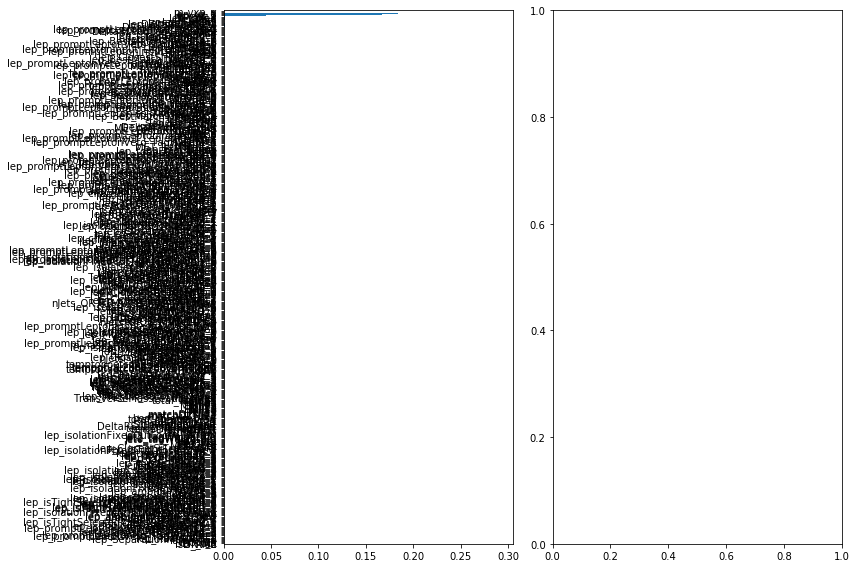

In [411]:
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
#tree_indices = np.arange(0, 20)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_noTr.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
fig.tight_layout()
plt.show()

In [316]:
tree_indices

array([5.000e-01, 1.500e+00, 2.500e+00, 3.500e+00, 4.500e+00, 5.500e+00,
       6.500e+00, 7.500e+00, 8.500e+00, 9.500e+00, 1.050e+01, 1.150e+01,
       1.250e+01, 1.350e+01, 1.450e+01, 1.550e+01, 1.650e+01, 1.750e+01,
       1.850e+01, 1.950e+01, 2.050e+01, 2.150e+01, 2.250e+01, 2.350e+01,
       2.450e+01, 2.550e+01, 2.650e+01, 2.750e+01, 2.850e+01, 2.950e+01,
       3.050e+01, 3.150e+01, 3.250e+01, 3.350e+01, 3.450e+01, 3.550e+01,
       3.650e+01, 3.750e+01, 3.850e+01, 3.950e+01, 4.050e+01, 4.150e+01,
       4.250e+01, 4.350e+01, 4.450e+01, 4.550e+01, 4.650e+01, 4.750e+01,
       4.850e+01, 4.950e+01, 5.050e+01, 5.150e+01, 5.250e+01, 5.350e+01,
       5.450e+01, 5.550e+01, 5.650e+01, 5.750e+01, 5.850e+01, 5.950e+01,
       6.050e+01, 6.150e+01, 6.250e+01, 6.350e+01, 6.450e+01, 6.550e+01,
       6.650e+01, 6.750e+01, 6.850e+01, 6.950e+01, 7.050e+01, 7.150e+01,
       7.250e+01, 7.350e+01, 7.450e+01, 7.550e+01, 7.650e+01, 7.750e+01,
       7.850e+01, 7.950e+01, 8.050e+01, 8.150e+01, 

In [319]:

tree_importance_sorted_idx_short

array([  0, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 429, 445, 428, 426])

In [320]:
X.columns[tree_importance_sorted_idx_short]

Index(['entry', 'lep_topoEtcone20_3', 'lep_topoEtcone30_3',
       'lep_topoEtcone40_3', 'lep_ptVarcone20_3', 'lep_ptVarcone30_3',
       'lep_ptVarcone40_3', 'lep_sigd0PV_3', 'lep_Z0SinTheta_3', 'lep_d0_3',
       'lep_z0_3', 'lep_vz_3', 'lep_deltaz0_3', 'lep_isTightLH_3',
       'lep_isMediumLH_3', 'lep_isLooseLH_3', 'lep_EtaBE2_3', 'lep_isTight_3',
       'lep_Phi_3', 'lep_E_3'],
      dtype='object')